# Detector Calibration using Volumetric Persistence

This notebook implements a comprehensive detector calibration workflow using the volumetric persistence method to detect peaks from known radioactive sources and calibrate detectors from channels to energy.

## Workflow Overview:
1. Load spectra data for all sources (Sodium, Cesium, Cobalt)
2. Apply channel filtering (remove channels < 250)
3. Detect peaks using volumetric persistence with source-specific top_k values
4. Apply peak selection rules to identify known emission peaks
5. Perform linear calibration for each detector
6. Evaluate calibration quality using leave-one-out cross-validation

In [10]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Include the project root directory in the import path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from core import find_peaks_volumetric_persistence
from utils import plot_volumetric_persistence_barcode, plot_spectrum_with_detected_peaks

## Configuration and Constants

In [11]:
# Source configuration
SOURCES = {
    'Sodium': {
        'sheet_name': 'Sodio I',
        'expected_energies': [0.511],  # MeV
        'top_k': 1
    },
    'Cesium': {
        'sheet_name': 'Cesio I', 
        'expected_energies': [0.662],  # MeV
        'top_k': 1
    },
    'Cobalt': {
        'sheet_name': 'Cobalto I',
        'expected_energies': [1.173, 1.332],  # MeV
        'top_k': 5  # Need more candidates to select the 2 highest energy peaks
    }
}

# Data configuration
DATA_FILE = "../Data/Dati_luglio.xlsx"
MIN_CHANNEL = 250  # Cut off channels below this to remove backscattering
NUM_DETECTORS = 128

# Peak finding parameters - optimized for gamma spectroscopy
PEAK_PARAMS = {
    'smoothing_range': [1, 3, 5],
    'bins_factor_range': [1, 2],
    'threshold_range': np.linspace(0, 0.004, 5),
    'width_range': np.linspace(1, 50, 5),
    'prominence_range': np.linspace(0.0001, 0.005, 5),
    'distance_range': np.array([1, 5, 10, 15, 20]),
    'merging_range': 10,
    'tol': 1,
    'parallel': True
}

# Plotting configuration
COLORS = {
    "spectrum": "#8499C4",
    "detected_peak": ["#C94040", "#69995D", "#CBAC88", "#394648", "#FF6B6B"],
    "alphas": [1.0, 1.0, 1.0, 1.0, 1.0],
    "linewidths": [2.0, 2.0, 2.0, 1.1, 1.5],
}

FONTSIZE = {
    "label": 14,
    "title": 16,
    "legend": 12,
}

## Utility Functions

In [12]:
def load_and_preprocess_spectrum(data_file, sheet_name, detector_idx, min_channel=MIN_CHANNEL):
    """
    Load and preprocess a single detector spectrum.
    
    Args:
        data_file: Path to Excel file
        sheet_name: Sheet name for the source
        detector_idx: Detector column index (0-127)
        min_channel: Minimum channel to keep (removes backscattering)
    
    Returns:
        tuple: (processed_spectrum, original_channels, channel_offset)
    """
    df = pd.read_excel(data_file, sheet_name=sheet_name)
    
    # Extract spectrum for this detector
    spectrum = df.iloc[:, detector_idx].to_numpy()
    
    # Apply channel filtering - keep channels >= min_channel
    filtered_spectrum = spectrum[min_channel:]
    original_channels = np.arange(min_channel, len(spectrum))
    
    # Normalize by area under curve
    normalized_spectrum = filtered_spectrum / np.trapz(filtered_spectrum)
    
    return normalized_spectrum, original_channels, min_channel


def select_known_peaks(peaks_info, source_name, channel_offset=MIN_CHANNEL):
    """
    Apply source-specific rules to select known emission peaks from detected peaks.
    
    Args:
        peaks_info: List of detected peaks from volumetric persistence
        source_name: Name of the source ('Sodium', 'Cesium', 'Cobalt')
        channel_offset: Offset to convert back to original channel numbers
    
    Returns:
        list: Selected peaks with original channel indices
    """
    if not peaks_info:
        return []
    
    # Convert peak indices back to original channel numbers
    for peak in peaks_info:
        peak['original_channel'] = peak['peak_index'] + channel_offset
    
    if source_name in ['Sodium', 'Cesium']:
        # For simple sources, take the most persistent peak
        return [peaks_info[0]] if peaks_info else []
    
    elif source_name == 'Cobalt':
        # For Cobalt, select the 2 highest-channel peaks among top candidates
        # These should correspond to the 1.173 and 1.332 MeV peaks
        if len(peaks_info) < 2:
            return peaks_info
        
        # Sort by original channel (energy proxy) and take the 2 highest
        sorted_by_channel = sorted(peaks_info, key=lambda x: x['original_channel'], reverse=True)
        return sorted_by_channel[:2]
    
    return []


def perform_linear_calibration(channels, energies):
    """
    Perform linear calibration from channels to energy.
    
    Args:
        channels: Array of channel positions
        energies: Array of corresponding energies in MeV
    
    Returns:
        tuple: (slope, intercept, r2_score)
    """
    if len(channels) < 2:
        return None, None, None
    
    # Fit linear regression: Energy = slope * Channel + intercept
    model = LinearRegression()
    X = np.array(channels).reshape(-1, 1)
    y = np.array(energies)
    
    model.fit(X, y)
    y_pred = model.predict(X)
    
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = r2_score(y, y_pred)
    
    return slope, intercept, r2


def leave_one_out_cv_error(channels, energies):
    """
    Calculate leave-one-out cross-validation error for calibration.
    
    Args:
        channels: Array of channel positions
        energies: Array of corresponding energies
    
    Returns:
        float: Mean squared error from cross-validation
    """
    if len(channels) < 3:  # Need at least 3 points for meaningful CV
        return np.nan
    
    loo = LeaveOneOut()
    X = np.array(channels).reshape(-1, 1)
    y = np.array(energies)
    
    cv_errors = []
    
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        error = (y_test[0] - y_pred[0])**2
        cv_errors.append(error)
    
    return np.mean(cv_errors)

## Main Calibration Workflow

In [13]:
def calibrate_single_detector(detector_idx, verbose=False):
    """
    Calibrate a single detector using all sources.
    
    Args:
        detector_idx: Detector index (0-127)
        verbose: Whether to print detailed information
    
    Returns:
        dict: Calibration results for this detector
    """
    calibration_points = []  # (channel, energy) pairs
    peak_detection_results = {}
    
    if verbose:
        print(f"\n=== Calibrating Detector {detector_idx} ===")
    
    # Process each source
    for source_name, config in SOURCES.items():
        if verbose:
            print(f"\nProcessing {source_name}...")
        
        try:
            # Load and preprocess spectrum
            spectrum, channels, channel_offset = load_and_preprocess_spectrum(
                DATA_FILE, config['sheet_name'], detector_idx
            )
            
            # Detect peaks using volumetric persistence
            peaks_info = find_peaks_volumetric_persistence(
                spectrum,
                top_k=config['top_k'],
                **PEAK_PARAMS
            )
            
            # Select known peaks based on source-specific rules
            selected_peaks = select_known_peaks(peaks_info, source_name, channel_offset)
            
            if verbose:
                print(f"  Detected {len(peaks_info)} peaks, selected {len(selected_peaks)}")
            
            # Store results
            peak_detection_results[source_name] = {
                'all_peaks': peaks_info,
                'selected_peaks': selected_peaks,
                'spectrum': spectrum,
                'channels': channels
            }
            
            # Add calibration points
            expected_energies = config['expected_energies']
            
            if len(selected_peaks) == len(expected_energies):
                # Sort peaks by channel for consistent pairing with energies
                sorted_peaks = sorted(selected_peaks, key=lambda x: x['original_channel'])
                
                for peak, energy in zip(sorted_peaks, sorted(expected_energies)):
                    calibration_points.append((peak['original_channel'], energy))
                    if verbose:
                        print(f"  Peak at channel {peak['original_channel']:.1f} -> {energy} MeV")
            else:
                if verbose:
                    print(f"  Warning: Expected {len(expected_energies)} peaks, found {len(selected_peaks)}")
        
        except Exception as e:
            if verbose:
                print(f"  Error processing {source_name}: {e}")
            continue
    
    # Perform calibration if we have enough points
    result = {
        'detector_idx': detector_idx,
        'calibration_points': calibration_points,
        'peak_detection_results': peak_detection_results,
        'slope': None,
        'intercept': None,
        'r2_score': None,
        'cv_error': None,
        'num_points': len(calibration_points)
    }
    
    if len(calibration_points) >= 2:
        channels, energies = zip(*calibration_points)
        
        # Linear calibration
        slope, intercept, r2 = perform_linear_calibration(channels, energies)
        result.update({
            'slope': slope,
            'intercept': intercept,
            'r2_score': r2
        })
        
        # Cross-validation error
        cv_error = leave_one_out_cv_error(channels, energies)
        result['cv_error'] = cv_error
        
        if verbose:
            print(f"\nCalibration Results:")
            print(f"  Slope: {slope:.6f} MeV/channel")
            print(f"  Intercept: {intercept:.6f} MeV")
            print(f"  R²: {r2:.4f}")
            print(f"  CV Error: {cv_error:.6f} MeV²")
    
    else:
        if verbose:
            print(f"\nInsufficient calibration points: {len(calibration_points)}")
    
    return result

## Test Calibration on a Single Detector

In [14]:
# Test the calibration workflow on detector 23 (same as in the original example)
test_detector = 23
test_result = calibrate_single_detector(test_detector, verbose=True)


=== Calibrating Detector 23 ===

Processing Sodium...
  Detected 1 peaks, selected 1
  Peak at channel 555.0 -> 0.511 MeV

Processing Cesium...
  Detected 1 peaks, selected 1
  Peak at channel 694.0 -> 0.662 MeV

Processing Cobalt...
  Detected 5 peaks, selected 2
  Peak at channel 1149.0 -> 1.173 MeV
  Peak at channel 1285.0 -> 1.332 MeV

Calibration Results:
  Slope: 0.001124 MeV/channel
  Intercept: -0.115600 MeV
  R²: 0.9999
  CV Error: 0.000038 MeV²


## Visualize Peak Detection Results for Test Detector

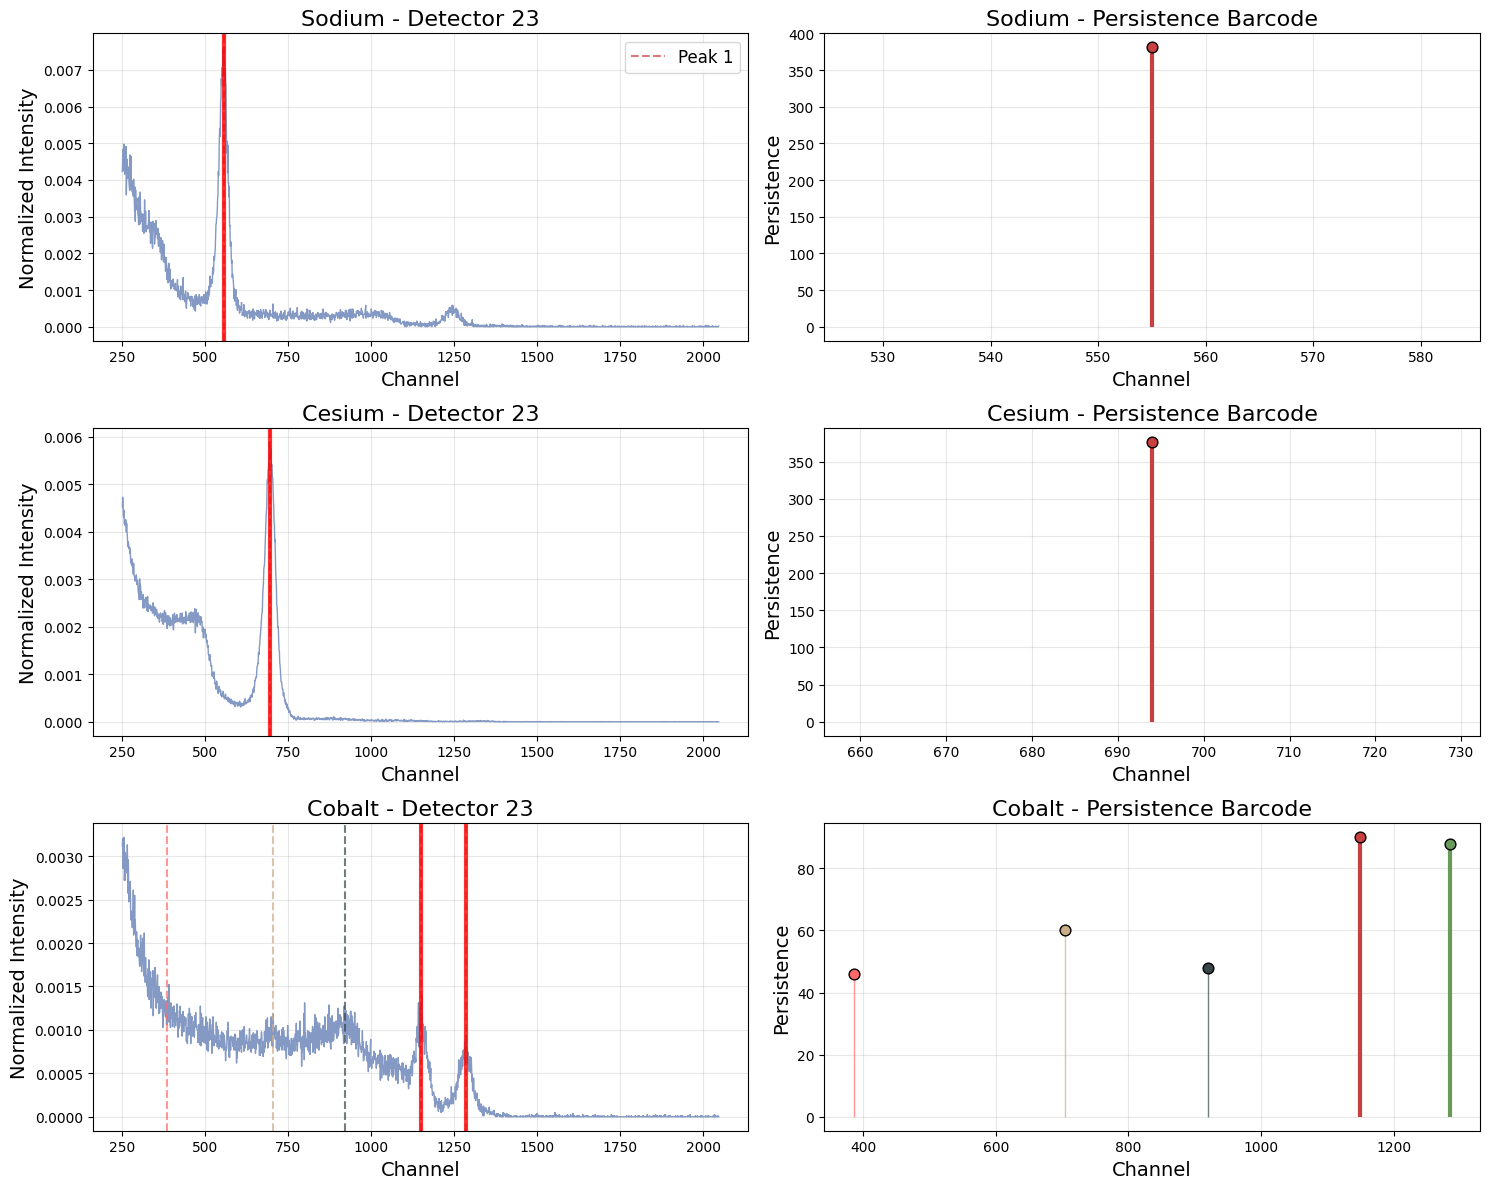

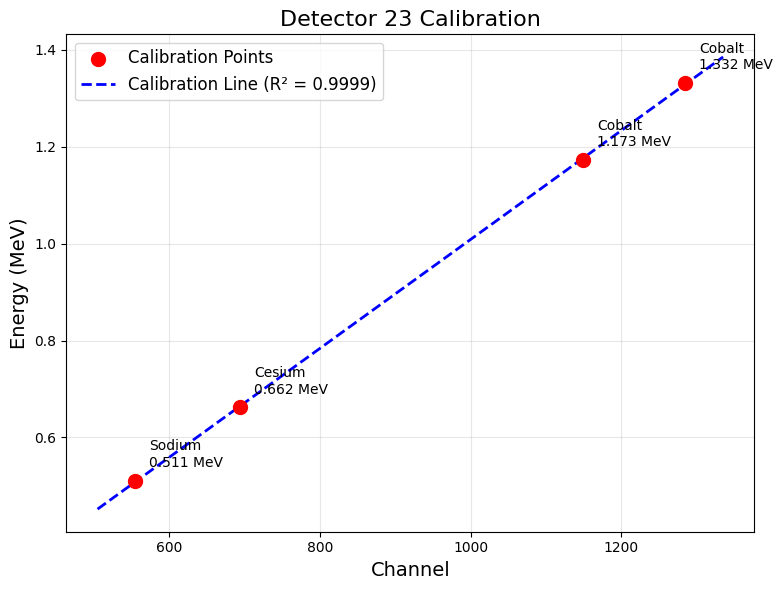

In [15]:
# Visualize peak detection for each source on the test detector
fig, axes = plt.subplots(len(SOURCES), 2, figsize=(15, 4*len(SOURCES)))
if len(SOURCES) == 1:
    axes = axes.reshape(1, -1)

for i, (source_name, detection_result) in enumerate(test_result['peak_detection_results'].items()):
    spectrum = detection_result['spectrum']
    channels = detection_result['channels']
    all_peaks = detection_result['all_peaks']
    selected_peaks = detection_result['selected_peaks']
    
    # Plot spectrum with all detected peaks
    plt.sca(axes[i, 0])
    plt.plot(channels, spectrum, color=COLORS['spectrum'], linewidth=1)
    
    # Mark all detected peaks
    for j, peak in enumerate(all_peaks[:5]):  # Show top 5
        color_idx = j % len(COLORS['detected_peak'])
        plt.axvline(peak['peak_index'] + MIN_CHANNEL, 
                   color=COLORS['detected_peak'][color_idx], 
                   linestyle='--', alpha=0.7,
                   label=f'Peak {j+1}' if j < 3 else None)
    
    # Highlight selected peaks
    for peak in selected_peaks:
        plt.axvline(peak['original_channel'], color='red', linewidth=3, alpha=0.8)
    
    plt.title(f'{source_name} - Detector {test_detector}', fontsize=FONTSIZE['title'])
    plt.xlabel('Channel', fontsize=FONTSIZE['label'])
    plt.ylabel('Normalized Intensity', fontsize=FONTSIZE['label'])
    plt.grid(True, alpha=0.3)
    if i == 0:  # Only show legend for first subplot
        plt.legend(fontsize=FONTSIZE['legend'])
    
    # Plot persistence barcode
    plt.sca(axes[i, 1])
    for rank, peak in enumerate(all_peaks[:5]):
        color_idx = rank % len(COLORS['detected_peak'])
        is_selected = any(p['peak_index'] == peak['peak_index'] for p in selected_peaks)
        linewidth = 3 if is_selected else 1
        alpha = 1.0 if is_selected else 0.7
        
        plt.vlines(peak['peak_index'] + MIN_CHANNEL, 0, peak['persistence'], 
                  colors=COLORS['detected_peak'][color_idx], 
                  linewidth=linewidth, alpha=alpha)
        plt.scatter(peak['peak_index'] + MIN_CHANNEL, peak['persistence'], 
                   color=COLORS['detected_peak'][color_idx], s=60, 
                   edgecolor='k', zorder=3)
    
    plt.title(f'{source_name} - Persistence Barcode', fontsize=FONTSIZE['title'])
    plt.xlabel('Channel', fontsize=FONTSIZE['label'])
    plt.ylabel('Persistence', fontsize=FONTSIZE['label'])
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show calibration line if successful
if test_result['slope'] is not None:
    plt.figure(figsize=(8, 6))
    
    channels, energies = zip(*test_result['calibration_points'])
    plt.scatter(channels, energies, color='red', s=100, zorder=3, label='Calibration Points')
    
    # Plot calibration line
    x_range = np.array([min(channels) - 50, max(channels) + 50])
    y_range = test_result['slope'] * x_range + test_result['intercept']
    plt.plot(x_range, y_range, 'b--', linewidth=2, 
             label=f'Calibration Line (R² = {test_result["r2_score"]:.4f})')
    
    # Annotate points with source names
    point_idx = 0
    for source_name, config in SOURCES.items():
        for energy in config['expected_energies']:
            if point_idx < len(channels):
                plt.annotate(f'{source_name}\n{energy} MeV', 
                           (channels[point_idx], energies[point_idx]),
                           xytext=(10, 10), textcoords='offset points',
                           fontsize=10, ha='left')
                point_idx += 1
    
    plt.xlabel('Channel', fontsize=FONTSIZE['label'])
    plt.ylabel('Energy (MeV)', fontsize=FONTSIZE['label'])
    plt.title(f'Detector {test_detector} Calibration', fontsize=FONTSIZE['title'])
    plt.legend(fontsize=FONTSIZE['legend'])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Calibrate All Detectors

In [ ]:
# Calibrate all detectors (this may take some time)
print("Calibrating all detectors...")
print("This may take several minutes depending on your system.")

all_results = []
successful_calibrations = 0

for detector_idx in tqdm(range(NUM_DETECTORS)):
    result = calibrate_single_detector(detector_idx, verbose=False)
    all_results.append(result)
    
    if result['slope'] is not None:
        successful_calibrations += 1

print(f"\nCalibration complete!")
print(f"Successfully calibrated {successful_calibrations}/{NUM_DETECTORS} detectors")
print(f"Success rate: {100*successful_calibrations/NUM_DETECTORS:.1f}%")

Calibrating all detectors...
This may take several minutes depending on your system.


 23%|██▎       | 30/128 [01:41<05:32,  3.40s/it]

## Analysis and Visualization of Results

In [8]:
# Extract results for analysis
detector_indices = []
slopes = []
intercepts = []
r2_scores = []
cv_errors = []
num_points = []

for result in all_results:
    detector_indices.append(result['detector_idx'])
    slopes.append(result['slope'])
    intercepts.append(result['intercept'])
    r2_scores.append(result['r2_score'])
    cv_errors.append(result['cv_error'])
    num_points.append(result['num_points'])

# Convert to numpy arrays for easier analysis
detector_indices = np.array(detector_indices)
slopes = np.array(slopes)
intercepts = np.array(intercepts)
r2_scores = np.array(r2_scores)
cv_errors = np.array(cv_errors)
num_points = np.array(num_points)

# Filter out failed calibrations for statistics
valid_mask = ~np.isnan(slopes)
valid_detectors = detector_indices[valid_mask]
valid_slopes = slopes[valid_mask]
valid_intercepts = intercepts[valid_mask]
valid_r2 = r2_scores[valid_mask]
valid_cv_errors = cv_errors[valid_mask]

print("=== Calibration Statistics ===")
print(f"Slope: {np.mean(valid_slopes):.6f} ± {np.std(valid_slopes):.6f} MeV/channel")
print(f"Intercept: {np.mean(valid_intercepts):.6f} ± {np.std(valid_intercepts):.6f} MeV")
print(f"R²: {np.mean(valid_r2):.4f} ± {np.std(valid_r2):.4f}")
print(f"CV Error: {np.mean(valid_cv_errors):.6f} ± {np.std(valid_cv_errors):.6f} MeV²")
print(f"CV RMSE: {np.sqrt(np.mean(valid_cv_errors)):.6f} MeV")

=== Calibration Statistics ===
Slope: 0.001299 ± 0.000207 MeV/channel
Intercept: -0.125608 ± 0.094529 MeV
R²: 0.9740 ± 0.0531
CV Error: 0.022563 ± 0.056365 MeV²
CV RMSE: 0.150211 MeV


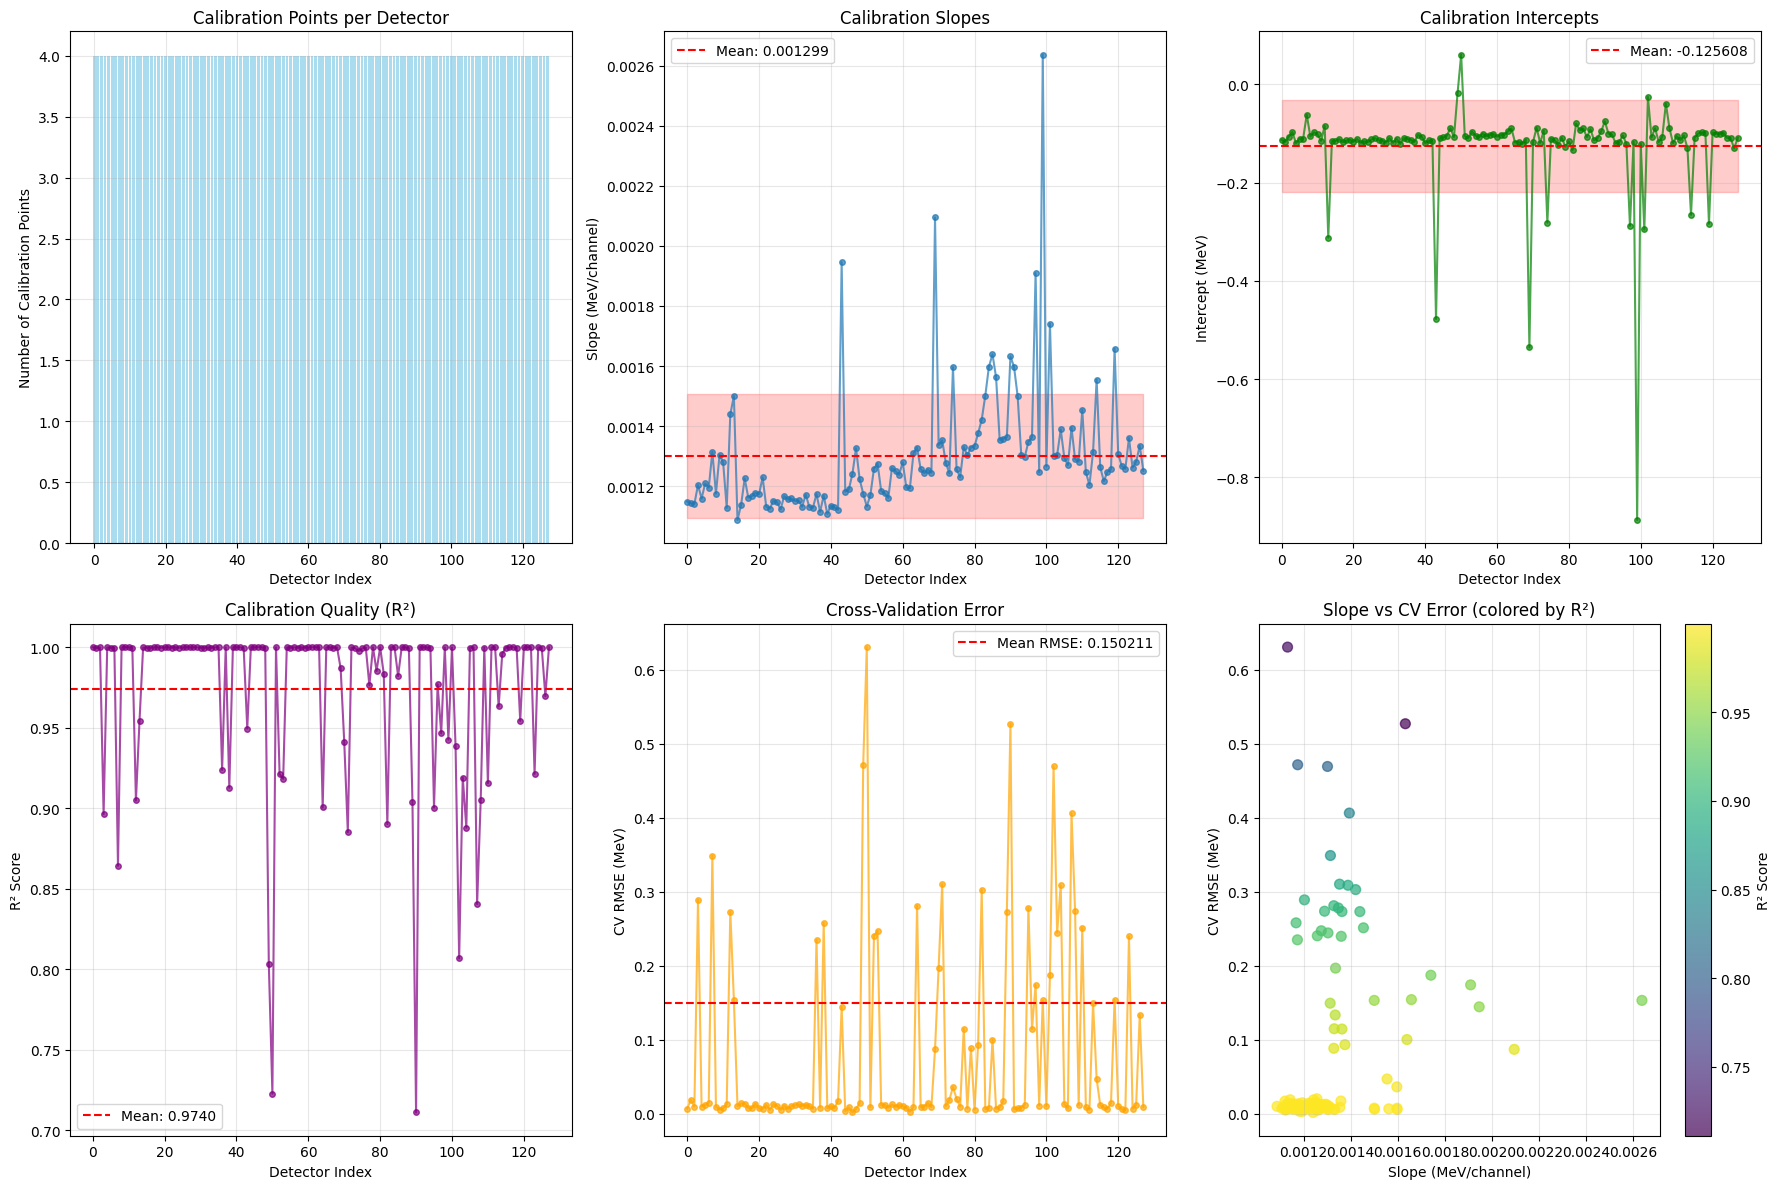

In [9]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Number of calibration points per detector
axes[0, 0].bar(detector_indices, num_points, alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Detector Index')
axes[0, 0].set_ylabel('Number of Calibration Points')
axes[0, 0].set_title('Calibration Points per Detector')
axes[0, 0].grid(True, alpha=0.3)

# 2. Slopes distribution
axes[0, 1].plot(valid_detectors, valid_slopes, 'o-', alpha=0.7, markersize=4)
axes[0, 1].axhline(np.mean(valid_slopes), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(valid_slopes):.6f}')
axes[0, 1].fill_between(valid_detectors, 
                        np.mean(valid_slopes) - np.std(valid_slopes),
                        np.mean(valid_slopes) + np.std(valid_slopes),
                        alpha=0.2, color='red')
axes[0, 1].set_xlabel('Detector Index')
axes[0, 1].set_ylabel('Slope (MeV/channel)')
axes[0, 1].set_title('Calibration Slopes')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Intercepts distribution
axes[0, 2].plot(valid_detectors, valid_intercepts, 'o-', alpha=0.7, markersize=4, color='green')
axes[0, 2].axhline(np.mean(valid_intercepts), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(valid_intercepts):.6f}')
axes[0, 2].fill_between(valid_detectors,
                        np.mean(valid_intercepts) - np.std(valid_intercepts),
                        np.mean(valid_intercepts) + np.std(valid_intercepts),
                        alpha=0.2, color='red')
axes[0, 2].set_xlabel('Detector Index')
axes[0, 2].set_ylabel('Intercept (MeV)')
axes[0, 2].set_title('Calibration Intercepts')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. R² scores
axes[1, 0].plot(valid_detectors, valid_r2, 'o-', alpha=0.7, markersize=4, color='purple')
axes[1, 0].axhline(np.mean(valid_r2), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(valid_r2):.4f}')
axes[1, 0].set_xlabel('Detector Index')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('Calibration Quality (R²)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Cross-validation errors
axes[1, 1].plot(valid_detectors, np.sqrt(valid_cv_errors), 'o-', alpha=0.7, markersize=4, color='orange')
axes[1, 1].axhline(np.sqrt(np.mean(valid_cv_errors)), color='red', linestyle='--', 
                   label=f'Mean RMSE: {np.sqrt(np.mean(valid_cv_errors)):.6f}')
axes[1, 1].set_xlabel('Detector Index')
axes[1, 1].set_ylabel('CV RMSE (MeV)')
axes[1, 1].set_title('Cross-Validation Error')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Slope vs CV Error scatter plot
scatter = axes[1, 2].scatter(valid_slopes, np.sqrt(valid_cv_errors), 
                            c=valid_r2, cmap='viridis', s=50, alpha=0.7)
axes[1, 2].set_xlabel('Slope (MeV/channel)')
axes[1, 2].set_ylabel('CV RMSE (MeV)')
axes[1, 2].set_title('Slope vs CV Error (colored by R²)')
axes[1, 2].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 2], label='R² Score')

plt.tight_layout()
plt.show()

## Summary Statistics and Quality Assessment

In [10]:
# Create summary statistics DataFrame
summary_stats = pd.DataFrame({
    'Detector': valid_detectors,
    'Slope_MeV_per_channel': valid_slopes,
    'Intercept_MeV': valid_intercepts,
    'R2_Score': valid_r2,
    'CV_RMSE_MeV': np.sqrt(valid_cv_errors),
    'Num_Calibration_Points': num_points[valid_mask]
})

print("=== Summary Statistics ===")
print(summary_stats.describe())

# Identify best and worst performing detectors
best_r2_idx = np.argmax(valid_r2)
worst_r2_idx = np.argmin(valid_r2)
lowest_cv_error_idx = np.argmin(valid_cv_errors)
highest_cv_error_idx = np.argmax(valid_cv_errors)

print("\n=== Performance Highlights ===")
print(f"Best R² Score: Detector {valid_detectors[best_r2_idx]} (R² = {valid_r2[best_r2_idx]:.4f})")
print(f"Worst R² Score: Detector {valid_detectors[worst_r2_idx]} (R² = {valid_r2[worst_r2_idx]:.4f})")
print(f"Lowest CV Error: Detector {valid_detectors[lowest_cv_error_idx]} (RMSE = {np.sqrt(valid_cv_errors[lowest_cv_error_idx]):.6f} MeV)")
print(f"Highest CV Error: Detector {valid_detectors[highest_cv_error_idx]} (RMSE = {np.sqrt(valid_cv_errors[highest_cv_error_idx]):.6f} MeV)")

# Quality thresholds
good_r2_threshold = 0.95
good_cv_rmse_threshold = 0.01  # MeV

good_r2_detectors = np.sum(valid_r2 >= good_r2_threshold)
good_cv_detectors = np.sum(np.sqrt(valid_cv_errors) <= good_cv_rmse_threshold)

print(f"\n=== Quality Assessment ===")
print(f"Detectors with R² ≥ {good_r2_threshold}: {good_r2_detectors}/{len(valid_detectors)} ({100*good_r2_detectors/len(valid_detectors):.1f}%)")
print(f"Detectors with CV RMSE ≤ {good_cv_rmse_threshold} MeV: {good_cv_detectors}/{len(valid_detectors)} ({100*good_cv_detectors/len(valid_detectors):.1f}%)")

# Save results to CSV
summary_stats.to_csv('detector_calibration_results.csv', index=False)
print(f"\nResults saved to 'detector_calibration_results.csv'")

=== Summary Statistics ===
         Detector  Slope_MeV_per_channel  Intercept_MeV    R2_Score  \
count  128.000000             128.000000     128.000000  128.000000   
mean    63.500000               0.001240      -0.106502    0.998925   
std     37.094474               0.000099       0.015898    0.004338   
min      0.000000               0.001088      -0.122446    0.976915   
25%     31.750000               0.001160      -0.115107    0.999708   
50%     63.500000               0.001236      -0.110024    0.999834   
75%     95.250000               0.001280      -0.104135    0.999898   
max    127.000000               0.001596      -0.028375    0.999992   

       CV_RMSE_MeV  Num_Calibration_Points  
count   128.000000                   128.0  
mean      0.013292                     4.0  
std       0.018190                     0.0  
min       0.001999                     4.0  
25%       0.007355                     4.0  
50%       0.009440                     4.0  
75%       0.012209

## Export Calibration Parameters

In [11]:
# Create a calibration function lookup table
calibration_functions = {}

for i, result in enumerate(all_results):
    detector_idx = result['detector_idx']
    if result['slope'] is not None:
        calibration_functions[detector_idx] = {
            'slope': result['slope'],
            'intercept': result['intercept'],
            'r2_score': result['r2_score'],
            'cv_rmse': np.sqrt(result['cv_error']) if not np.isnan(result['cv_error']) else np.nan
        }

print(f"Calibration functions available for {len(calibration_functions)} detectors")

# Example: Convert channel to energy for a calibrated detector
def channel_to_energy(channel, detector_idx):
    """
    Convert channel number to energy for a calibrated detector.
    
    Args:
        channel: Channel number
        detector_idx: Detector index
    
    Returns:
        Energy in MeV, or None if detector not calibrated
    """
    if detector_idx in calibration_functions:
        cal = calibration_functions[detector_idx]
        return cal['slope'] * channel + cal['intercept']
    return None

# Example usage
if test_detector in calibration_functions:
    example_channel = 1000
    example_energy = channel_to_energy(example_channel, test_detector)
    print(f"\nExample: Channel {example_channel} on detector {test_detector} corresponds to {example_energy:.4f} MeV")

# Save calibration functions as JSON for easy loading
import json

# Convert numpy types to Python types for JSON serialization
json_calibration = {}
for det_idx, cal_data in calibration_functions.items():
    json_calibration[str(det_idx)] = {
        'slope': float(cal_data['slope']),
        'intercept': float(cal_data['intercept']),
        'r2_score': float(cal_data['r2_score']),
        'cv_rmse': float(cal_data['cv_rmse']) if not np.isnan(cal_data['cv_rmse']) else None
    }

with open('detector_calibration_functions.json', 'w') as f:
    json.dump(json_calibration, f, indent=2)

print("Calibration functions saved to 'detector_calibration_functions.json'")

Calibration functions available for 128 detectors

Example: Channel 1000 on detector 23 corresponds to 1.0089 MeV
Calibration functions saved to 'detector_calibration_functions.json'
